In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from feature_selection import hybrid
from feature_selection import filter_method as ft
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

## Preprocessing (transformation/scaling)

In [2]:
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [4]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  din

In [5]:
combined_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(train['attack_cat'])

0.3193776697977085

In [9]:
tmp = test.where(test['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(test['attack_cat'])

0.44939999028324346

In [10]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())

attack cat: {'Worms', 'Generic', 'Exploits', 'Normal', 'Analysis', 'DoS', 'Backdoor', 'Reconnaissance', 'Fuzzers', 'Shellcode'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32


In [11]:
print("mode", len(np.where(vector.values==6)[0])/len(vector))

mode 0.3609225646458884


In [12]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

## Missing value checking¶

In [13]:
from feature_cleaning import missing_data as ms

In [14]:
ms.check_missing(data=combined_data,output_path=r'C:\Users\User\ML-Mid')

result saved at C:\Users\User\ML-Mid missing.csv


,total missing,proportion
dur,0,0.0
proto,0,0.0
service,0,0.0
state,0,0.0
spkts,0,0.0
dpkts,0,0.0
sbytes,0,0.0
dbytes,0,0.0
rate,0,0.0
sttl,0,0.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(combined_data.drop(labels=['attack_cat','label'], axis=1), 
                                                    combined_data.label, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((206138, 42), (51535, 42))

In [18]:
corr = ft.corr_feature_detect(data=X_train,threshold=0.9)
# print all the correlated feature groups!
for i in corr:
    print(i,'\n')

     feature1      feature2      corr
0  ct_ftp_cmd  is_ftp_login  0.998762 

   feature1 feature2      corr
2     dloss   dbytes  0.996485
10    dloss    dpkts  0.979011 

   feature1 feature2      corr
4     sloss   sbytes  0.995571
15    sloss    spkts  0.971246 

  feature1 feature2      corr
6     swin     dwin  0.980553 

      feature1        feature2      corr
8   ct_srv_dst      ct_srv_src  0.979610
21  ct_srv_dst  ct_dst_src_ltm  0.960429 

            feature1          feature2      corr
18  ct_src_dport_ltm        ct_dst_ltm  0.961239
31  ct_src_dport_ltm        ct_src_ltm  0.909852
32  ct_src_dport_ltm  ct_dst_sport_ltm  0.908318 

   feature1         feature2      corr
24   sinpkt  is_sm_ips_ports  0.943253 

   feature1 feature2      corr
26   tcprtt   synack  0.942197
28   tcprtt   ackdat  0.919032 



In [22]:
combined_data_2 = combined_data.drop(['ct_ftp_cmd','is_ftp_login','dloss','dbytes','sloss','sbytes','spkts','swin','dwin',
                                      'ct_srv_dst','ct_srv_src','ct_dst_src_ltm','ct_src_dport_ltm','ct_dst_ltm','ct_src_ltm',
                                      'ct_dst_sport_ltm','sinpkt','is_sm_ips_ports','tcprtt','synack','ackdat'],axis=1)

In [23]:
cor = combined_data_2.corr()

<Figure size 1152x720 with 0 Axes>

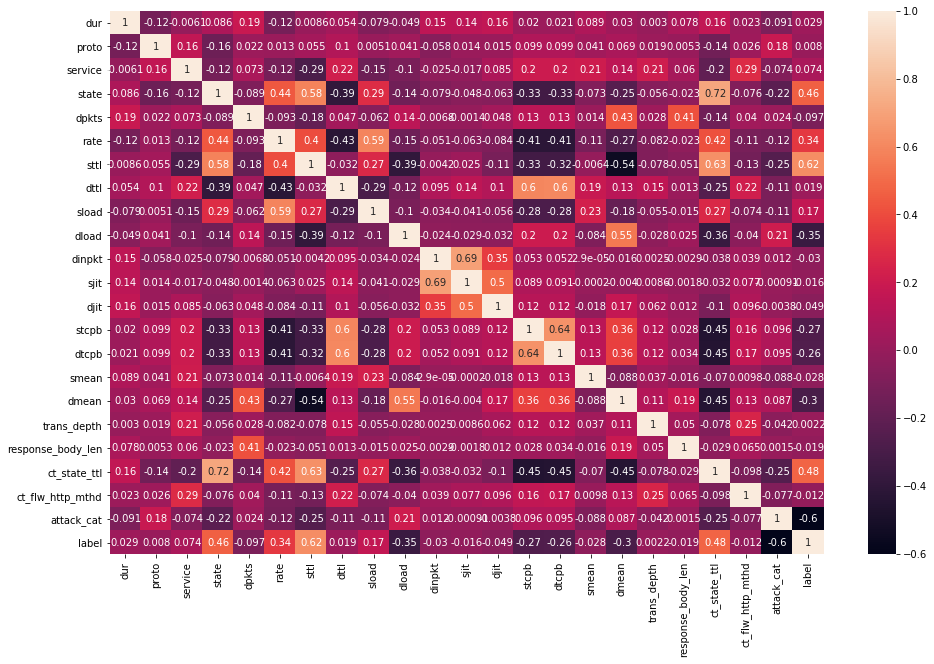

In [24]:
plt.figure(figsize=(16,10))
sns.heatmap(cor,annot=True)
plt.show()

# Step Forward Feature Selection (SFFS)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(combined_data_2.drop(labels=['attack_cat','label'], axis=1), 
                                                    combined_data_2.label, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((206138, 21), (51535, 21))

In [26]:
# step forward feature selection
# select top 10 features based on the optimal roc_auc and RandomForest Classifier

sfs1 = SFS(RandomForestClassifier(n_jobs=-1,n_estimators=5), 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=1,
           scoring='roc_auc',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.1min finished
Features: 1/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   46.2s finished
Features: 2/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   43.5s finished
Features: 3/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   45.4s finished
Features: 4/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   45.3s finished
Features: 5/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   39.6s finished
Features: 6/10[Parallel(

# Till Now These Features works Best

In [27]:
selected_feat1= X_train.columns[list(sfs1.k_feature_idx_)]
selected_feat1

Index(['proto', 'service', 'dpkts', 'sttl', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_state_ttl', 'ct_flw_http_mthd'],
      dtype='object')

# Other Methods

In [30]:
combined_data_3 = combined_data.loc[:,['attack_cat','proto', 'service', 'dpkts', 'sttl', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_state_ttl', 'ct_flw_http_mthd','label']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(combined_data_3.drop(labels=['attack_cat','label'], axis=1), 
                                                    combined_data_3.label, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((206138, 10), (51535, 10))

In [32]:
features_to_keep = hybrid.recursive_feature_addition_rf(X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test,
                                                        y_test=y_test,
                                                        tol=0.001)


testing feature:  service  which is feature  1  out of  10
New Test ROC AUC=0.811207682759567
All features Test ROC AUC=0.7458934459364767
Increase in ROC AUC=0.06531423682309034
keep:  service

testing feature:  dpkts  which is feature  2  out of  10
New Test ROC AUC=0.9542006577454162
All features Test ROC AUC=0.811207682759567
Increase in ROC AUC=0.14299297498584917
keep:  dpkts

testing feature:  sttl  which is feature  3  out of  10
New Test ROC AUC=0.9688623315288645
All features Test ROC AUC=0.9542006577454162
Increase in ROC AUC=0.014661673783448292
keep:  sttl

testing feature:  smean  which is feature  4  out of  10
New Test ROC AUC=0.9833083699606944
All features Test ROC AUC=0.9688623315288645
Increase in ROC AUC=0.0144460384318299
keep:  smean

testing feature:  dmean  which is feature  5  out of  10
New Test ROC AUC=0.9847455158837364
All features Test ROC AUC=0.9833083699606944
Increase in ROC AUC=0.0014371459230420047
keep:  dmean

testing feature:  trans_depth  which 

In [33]:
features_to_keep

['proto', 'service', 'dpkts', 'sttl', 'smean', 'dmean']